In [58]:
#@title Imports  { form-width: "30%" }

from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import collections
import itertools
import time

from graph_nets import graphs
from graph_nets import utils_np
from graph_nets import utils_tf
from graph_nets import blocks
from graph_nets.demos import models

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from scipy import spatial
import tensorflow as tf
import sonnet as snt
#import random

import math
import threading
import time



In [59]:
""" 全局变量定义　"""
# alpha_agents,数目设定
ALPHA_AGENTS_NUM = 50
# alpha_agnets探测距离r(meter)
DETECTION_RANGE = 500
# flocking 间距d(meter)，小于等于agents的探测范围r
FLOCKING_DISTANCE = 1000
# 圆周率PI
PI = 3.1415
# 单位时间alpha_agents单步迭代，位移动作距离STEP_DRIFT(meter)
STEP_DRIFT = 0.5

# 生成全局地图(10000m * 10000m)
WIDTH = 10000  # meter
LENGTH = 10000  # meter

In [60]:
"""得到初始状态矩阵: S_0 """
mapSquare = [WIDTH,LENGTH]  
print(mapSquare)
# 设定alpha_agents属性：初始位置，探测范围，初始速度，

# 设定alpha_agents属性：
# @ alphaAgentsNum: 集群数目
# @ alphaAgentsNum: 集群位置矩阵
# @ alphaAgentsInitialSpeed: 集群初始速度矩阵
# @ alphaAgentsDetectionRange: alpha_agents探测范围(meter)       
# 生成指定数目alpha_agents的随机位置和初始随机速度
# @ alphaAgentsInitialPos [50,5]矩阵,[[pos_x,pos_y,0,0,0],....]
# @ alphaAgentsInitialSpeed [50,5]矩阵,[[v_x, v_y],0,0,0]设定范围在[0,5](m/s)
posArray = np.zeros((50,5))
speedArray = np.zeros((50,5))
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

for i in range(ALPHA_AGENTS_NUM):
    posArray[i][0] = np.random.randint(0,mapSquare[1])  # pos_x
    posArray[i][1] = np.random.randint(0,mapSquare[1])  # pos_y
    posArray[i][2] = i  # 设定alpha_agents的全局唯一编号AGENT_NUM
for i in range(ALPHA_AGENTS_NUM):
    speedArray[i][0] = 1 # v_x([0,5]m/s)
    speedArray[i][1] = 1 # v_y([0,5]m/s)
    speedArray[i][2] = i
    
# 初始化状态矩阵：S_0    
alphaAgentsInitialPos = posArray
# 初始化速度矩阵：v_0
alphaAgentsInitialSpeed = speedArray


[10000, 10000]


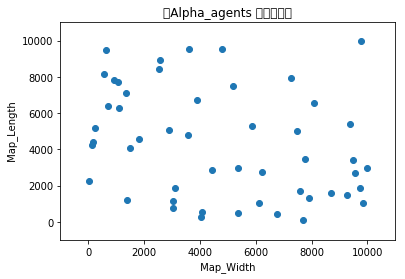

In [61]:
"""
得到初始位置，初始速度
"""
# check part.
List1 = []
List2 = []
for i in range(50):
    tmp1 = alphaAgentsInitialPos[i][0]
    tmp2 = alphaAgentsInitialPos[i][1]
    List1.append(tmp1)
    List2.append(tmp2)
x = List1
y = List2
# check part.
plt.scatter(x,y)
plt.title("　Alpha_agents 初始位置　")
plt.xlabel(" Map_Width ")
plt.ylabel(" Map_Length ")
plt.axis([-1000,11000,-1000,11000])
plt.show()

In [62]:
"""通过graph_nets.lib 进行图神经网络初始化
# 初始化主要包含几个存储函数，几个计算函数，以及相应的更新函数
# 存储函数主要是存储：Flocking状态序列S_t=[...,S_i_t,...]，回报序列R_t=[...,R_i_t,...],
    策略序列PI_t==[...,PI_i_t,...],动作序列A_t = =[...,A_i_t,...]
# 计算函数主要是计算：根据策略计算动作PI_t->S_t；根据动作计算新的状态A_t->S_t+1;根据经验计算新策略
    PI_t->PI_t+1;根据新状态计算回报值S_t+1->R_t+1
"""
# T 为一次训练迭代的总次数
T = 1000000
# 存储函数,存储这里用
# 每一条边，每一个节点的每一个属性都根据时间序列做一个List
def exps_saved_Fun(boolStamp, timeStamp, dataArray, fileName):
    t = timeStamp
    boolTmp = boolStamp
    # 需要保存的数据
    savedData = dataArray
    # 需要将数据保存到的位置
    savedFile = fileName
    if (boolTmp == True and t <= T):
        np.savetxt("{}{}.txt".format(savedFile, t),savedData)  
    else:
        pass

In [63]:
# 计算函数主要是计算：根据策略计算动作PI_t->S_t；根据动作计算新的状态A_t->S_t+1;根据经验计算新策略
#  PI_t->PI_t+1;根据新状态计算回报值S_t+1->R_t+1
GLOBAL_SIZE = 5
NODE_SIZE = 5
EDGE_SIZE = 5

# 根据顶点状态矩阵 nodes　计算边的属性矩阵　edges
# 要返回：edges,senders,receivers
def get_edges_from_nodes_fun(nodes):
    ListTmp = get_neighboursArray_from_nodes(nodes)
    arrayRelTmp1 = ListTmp[0]  # 邻接关系(0-1)矩阵
    arrayDisTmp2 = ListTmp[1]  # 邻接关系矩阵下的距离矩阵
    
    #print("arrayRelTmp1",arrayRelTmp1)
    #print("arrayDisTmp2",arrayDisTmp2)
    # 计算返回边属性数组: edges
    # 边的条数计算,是[0-1]邻接矩阵所有元素和减去顶点个数ALPHA_AGENTS_NUM
    num_edges = int(int(np.sum(arrayRelTmp1)) - ALPHA_AGENTS_NUM)
    # 知道了边的条数之后，将边的初始属性全部赋值为0
    # 距离属性放在[0]位置,[1],[2]位置放置sender_node和receiver_node的编号
    
    # 根据邻接关系矩阵下的距离矩阵计算当前边的属性
    # 用邻接矩阵来进行边矩阵计算
    edges = []
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            tmpList1 = [0,0,0,0,0]
            if (arrayRelTmp1[i][j] == 1 and i != j):
                tmpList1[0] = arrayDisTmp2[i][j]
                tmpList1[1] = i
                tmpList1[2] = j
                # 边属性的唯一编号对用来表示
                tmpList1[3] = i*1000000 + j*100 
                edges.append(tmpList1)


    #print("edges_0",edges)
    #senders = np.zeros((num_edges))
    #receivers = np.zeros((num_edges))
    #for i in range(num_edges):
     #   senders[i] = edges[i][1]   
     #   receivers[i] = edges[i][2] 
    #print("***************",num_edges,len(edges))
    senders = []
    receivers = []
    for i in range(num_edges):
        senders.append(edges[i][1])  
        receivers.append(edges[i][2])
            
    return [edges, senders, receivers]
    
# 从　nodes矩阵计算edges
# nodes 的属性是np.array数组,([50,5])
def get_neighboursArray_from_nodes(nodes):
    # 每一个顶点都是sender,
    # 每一个顶点UUV的邻居都作为receivers
    # senders,receivers可用邻接矩阵来计算
    neighboursArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))  # 邻接矩阵receiversArray[50][50]
    neighboursDisArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))
    
    #print("neighboursArray",neighboursArray)
    #print("neighboursDisArray",neighboursDisArray)
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            neighbourDis = np.sqrt(np.square(nodes[i][0] - nodes[j][0]) + 
                                   np.square(nodes[i][1] - nodes[j][1]))
            deltaDis = neighbourDis - 2000  
            neighboursDisArray[i][j] = neighbourDis
            # 如果邻居在探测范围之内则建立通讯连接
            if deltaDis < 0 :
                neighboursArray[i][j] = 1
                
    return [neighboursArray, neighboursDisArray]  # 返回邻接关系矩阵和当前邻接关系下的实时位置关系矩阵(距离)
    

"""先生成无参数的顶点图，图的顶点个数为：ALPHA_AGENTS_NUM = 50"""
def get_graph_data_dict_0():
    nodes = alphaAgentsInitialPos
    tmpList = get_edges_from_nodes_fun(nodes)
    return {
      "globals": np.random.rand(GLOBAL_SIZE),
      "nodes": nodes,
      "edges": tmpList[0],
      "senders": tmpList[1],
      "receivers": tmpList[2],
    }



def plot_graphs_tuple_np(graphs_tuple):
    networkx_graphs = utils_np.graphs_tuple_to_networkxs(graphs_tuple)
    num_graphs = len(networkx_graphs)
    _, axes = plt.subplots(1, num_graphs, figsize=(8*num_graphs, 8))
    if num_graphs == 1:
        axes = axes,
    for graph, ax in zip(networkx_graphs, axes):
        plot_graph_networkx(graph, ax)


def plot_graph_networkx(graph, ax, pos=None):
    node_labels = {node: "{:.3g}".format(data["features"][0])
                 for node, data in graph.nodes(data=True)
                 if data["features"] is not None}
    edge_labels = {(sender, receiver): "{:.3g}".format(data["features"][0])
                 for sender, receiver, data in graph.edges(data=True)
                 if data["features"] is not None}
    global_label = ("{:.3g}".format(graph.graph["features"][0])
                  if graph.graph["features"] is not None else None)

    if pos is None:
        pos = nx.spring_layout(graph)
    nx.draw_networkx(graph, pos, ax=ax, labels=node_labels)

    if edge_labels:
        nx.draw_networkx_edge_labels(graph, pos, edge_labels, ax=ax)

    if global_label:
        plt.text(0.05, 0.95, global_label, transform=ax.transAxes)#参数信息：plt.text(x,y,s,family,fontsize,style,color)说明
                                                                #x,y代表注释内容位置，s代表注释文本内容，family设置字体，自带的可选项有{'serif', 'sans-serif', 'cursive', 'fantasy', 'monospace'}，fontsize字体大小，style设置字体样式，可选项{'normal', 'italic'(斜体), 'oblique'(也是斜体)}



    ax.yaxis.set_visible(False)
    ax.xaxis.set_visible(False)
    return pos


def plot_compare_graphs(graphs_tuples, labels):
    pos = None
    num_graphs = len(graphs_tuples)
    _, axes = plt.subplots(1,num_graphs, figsize=(5*num_graphs,5))
    if num_graphs == 1:
        axes = axes,
    pos = None
    for name, graphs_tuple, ax in zip(labels, graphs_tuples, axes):
        graph = utils_np.graphs_tuple_to_networkxs(graphs_tuple)[0]
        pos = plot_graph_networkx(graph, ax, pos=pos)
        ax.set_title(name)

#graph_dicts = [get_graph_data_dict_0()]
#print(graph_dicts)
#tf.reset_default_graph()
#graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)

#with tf.Session() as sess:
#    graphs_tuple_np = sess.run(graphs_tuple_tf)
#    exps_saved_Fun(boolStamp=True,timeStamp=0,dataArray=graphs_tuple_np.edges,fileName="graphs_tuple_np")
    

#plot_graphs_tuple_np(graphs_tuple_np)  # 现在知道了S_0


In [107]:
# *******************************************************************************#
"""计算回报矩阵"""
# 目标终止状态是每条边的边长为FLOCKING_DISTANCE=300m,即边属性矩阵的edgeState_T=[1..1]
# 且同时，邻接矩阵(ALPHA_AGENT_NUM,ALPHA_AGENTS_NUM)维度的neighborRelation=[1....1]为单位矩阵
# 由graphs_tuple_np.nodes可以计算出邻接矩阵

# 首先初始化edgeReward_t和edgeRewardHistory
def get_edge_reward_init(graphs_tuple_np_new):
    edgeRewardHistoryInit = []  # 初始设定回报经验是一个空列表[edgeReward_0,...,edgeReward_t]
    # 第i条边的回报经验也是一个空列表  
    graphs_tuple_np = graphs_tuple_np_new
    edgeState_t = graphs_tuple_np.edges
    numDim = len(edgeState_t)
    for i in range(numDim):
        edgeReward_t = []  #第i条边第t时刻的回报是个确定的数值[edgeCode,...,edgeReward_i_t]
        edgeCode = edgeState_t[i][3]  # 得到当前边的唯一编号 
        edgeReward_t.append(edgeCode)
        edgeRewardValue_i_t = ((edgeState_t[i][0]
                                        -FLOCKING_DISTANCE)/FLOCKING_DISTANCE)
        edgeReward_t.append(edgeRewardValue_i_t)
        edgeRewardHistoryInit.append(edgeReward_t)
    return edgeRewardHistoryInit

# 计算每一步的新回报并生成新的edgeRewardHistory    
def get_edge_reward(output_graphs, edgeRewardHistory):  
    # 重新生成新的与当前时刻边的数目(维度)相同的边回报矩阵
    edgeRewardHistoryNew = []
    edgeState_t = output_graphs.edges
    numDim = len(edgeState_t)
    for i in range(numDim):
        edgeReward_t = []  #第i条边第t时刻的回报是个确定的数值[edgeCode,...,edgeReward_i_t]
        edgeCode = edgeState_t[i][3]  # 得到当前边的唯一编号 
        edgeReward_t.append(edgeCode)
        edgeRewardHistoryNew.append(edgeReward_t)
    # 将前一时刻的edgeRewardHistory全部放到新生成的edgeRewardHistoryNew里面
    tmpNew = len(edgeRewardHistoryNew)
    tmpPre = len(edgeRewardHistory)
    for i in range(tmpNew):
        for j in range(tmpPre):
            if edgeRewardHistoryNew[i][0] == edgeRewardHistory[j][0]:
                edgeRewardHistoryNew[i] = edgeRewardHistory[j] 
    # 将当前时刻新的回报存进新的经验矩阵中，得到新的经验矩阵
    numDim = len(edgeState_t)
    for i in range(tmpNew): 
        for j in range(numDim):
            if edgeRewardHistoryNew[i][0] == edgeState_t[j][3]:
                # edgeReward_t = [] ;第i条边第t时刻的回报是个确定的数值[edgeCode,...,edgeReward_i_t]
                edgeRewardValue_i_t = ((edgeState_t[j][0]
                                        -FLOCKING_DISTANCE)/FLOCKING_DISTANCE)
                # 计算第i条边第t时刻的回报值,存进策略回报经验中去
        edgeRewardHistoryNew[i].append(edgeRewardValue_i_t)
                
    edgeRewardHistory = edgeRewardHistoryNew
    return edgeRewardHistory
#***********************************************************************************#    



#***********************************************************************************#
""" 计算策略矩阵 """
# 当前具有给定一个前ｋ步的策略矩阵，当前初始属性
# 策略矩阵是基于当前状态S_t和策略经验来进行综合计算得到的
# state_t是gn在t时刻得到的计算图的属性：graphs_tuple_np.edges，是一个(n,5)的矩阵

# 初始化edgePolicy_t和edgePolicyHistory
def get_edge_policy_init(graphs_tuple):
    graphs_tuple_np = graphs_tuple
    edgeState_t = graphs_tuple_np.edges
    edgePolicyHistoryInit = []  # 初始设定回报策略是一个空列表[edgePolicy_0,...,edgePolicy_t]
    # 第i条边的策略经验也是一个空列表   
    numDim = len(edgeState_t)
    for i in range(numDim):
        edgePolicy_t = []  #第i条边第t时刻的策略是个确定的数值[edgeCode,...,edgeReward_i_t]
        edgeCode = edgeState_t[i][3]  # 得到当前边的唯一编号 
        edgePolicy_t.append(edgeCode)
        edgePolicy_t.append(0)
        edgePolicyHistoryInit.append(edgePolicy_t)
    return edgePolicyHistoryInit

# 计算第i条边第t时刻的策略是个确定的数值
def get_edge_policy(graphs_tuple_np,edgePolicyHistory,edgeRewardHistory):
    # 重新生成新的与当前时刻边的数目(维度)相同的边策略矩阵
    edgePolicyHistoryNew = get_edge_policy_init(graphs_tuple_np)
    GAMA = 0.9  # GAMA是策略经验学习的衰减系数
    # 将前一时刻的edgePolicyHistory全部放到新生成的edgePolicyHistoryNew里面
    tmpNew = len(edgePolicyHistoryNew)
    tmpPre = len(edgePolicyHistory)
    for i in range(tmpNew):
        for j in range(tmpPre):
            if edgePolicyHistoryNew[i][0] == edgePolicyHistory[j][0]:
                edgePolicyHistoryNew[i] = edgePolicyHistory[j] 
    # 将当前时刻新的策略存进新的经验矩阵中，得到新的策略经验矩阵
    edgeState_t = graphs_tuple_np.edges
    numDim = len(edgeState_t)
    num_t = len(edgePolicyHistoryNew[0])
    for i in range(tmpNew):
        for j in range(numDim):
            if edgePolicyHistoryNew[i][0] == edgeState_t[j][3]:
                if num_t > 6:
                    # edgeReward_t = [] ;第i条边第t时刻的回报是个确定的数值[edgeCode,...,edgePolicy_i_t]
                    edgePolicyValue_i_t = (((edgePolicyHistoryNew[i][-1]*GAMA)
                                       +(pow(GAMA,2)*edgePolicyHistoryNew[i][-2])
                                       +(pow(GAMA,3)*edgePolicyHistoryNew[i][-3])
                                       +(pow(GAMA,4)*edgePolicyHistoryNew[i][-4])
                                       +(pow(GAMA,5)*edgePolicyHistoryNew[i][-5]))
                                           *(edgeRewardHistory[i][-1]-edgeRewardHistory[i][-2]))
                else:
                    edgePolicyValue_i_t = (edgeRewardHistory[i][-1] * 1)
        edgePolicyHistoryNew[i].append(edgePolicyValue_i_t)
    edgePolicyHistory = edgePolicyHistoryNew
    return edgePolicyHistory  # 根据计算生成edgePolicyHistory[]二维数组
#***********************************************************************************#

"""计算边的Action"""
# 构建一个函数，来计算由状态state_t|policy_t-->state_t+1
# 构建动作矩阵edgeActions_t，维度与edgeState_t相同，
# 执行动作的时，只需要 edgeActions_tplus = tf.add(edgeState_t,edgeActions_t)
def get_edge_state_tplus(graphs_tuple_np,edgePolicyHistory):
    edgeState_t = graphs_tuple_np.edges
    numPolicy = len(edgePolicyHistory)
    numDim = len(edgeState_t)
    for i in range(numDim):
        for j in range(numDim):
            if edgePolicyHistory[j][0] == edgeState_t[j][3]:
                edgeState_t[i][0] = edgeState_t[i][0] + edgePolicyHistory[j][-1]
    edgeState_tplus = edgeState_t
    return edgeState_tplus

"""得到了新的图的顶点属性"""
def get_graph_data_nodes_tplus(graphs_tuple_np,edgePolicyHistory):
    edgeState_t = graphs_tuple_np.edges
    edgeState_tplus = get_edge_state_tplus(graphs_tuple_np,edgePolicyHistory)
    nodesState_t = graphs_tuple_np.nodes
    nodeState_tplus = nodesState_t
    #print("edgeState_tplus",edgeState_tplus)
    #print("nodesState_t",nodesState_t)
    # 根据相应的edges属性更新顶点编号对应的receiverNodes顶点属性
    # 边属性的唯一编号对用来表示
    #tmpList1[3] = i*1000000 + j*100
    for i in range(len(edgeState_tplus)):
        for j in range(len(edgeState_t)):
            if edgeState_tplus[i][3] == edgeState_t[j][3]:
                senderCode = int(edgeState_tplus[i][1])
                receiverCode = int(edgeState_tplus[i][2])
                senderNode_t = nodesState_t[senderCode]
                receiverNode_t = nodesState_t[receiverCode]
                deltaEdge = edgeState_tplus[i][0]-edgeState_t[j][0]
                receiverNode_tplus = update_nodes_from_edges(graphs_tuple_np,
                                        senderNode_t,receiverNode_t,deltaEdge)
            nodeState_tplus[receiverCode] = receiverNode_tplus
        #这地方有问题
    
    nodes_tplus = nodeState_tplus    
    #print("nodes_tplus",nodes_tplus)
    return nodes_tplus

# 知道边属性编号及更新策略，计算更新顶点属性
def update_nodes_from_edges(graphs_tuple_np,senderNode_t,receiverNode_t,deltaEdge):
    receiverNode_tplus = receiverNode_t
    #senderReceiverDis = np.sqrt(pow((receiverNode_t[0]-senderNode_t[0]),2)
    #                             + pow((receiverNode_t[1]-senderNode_t[1]),2))
    # receiverNode沿边属性更新方向向sederNode移动一定距离
    receiverNode_tplus[0] = (receiverNode_t[0]- (deltaEdge/2))  #计算pos_x的变化
    receiverNode_tplus[1] = (receiverNode_t[1]- (deltaEdge/2))  #计算pos_y的变化
    return receiverNode_tplus #返回更新后的receiverNodes属性

# 将新的顶点位置，边属性，根据新的顶点位置计算得到的senders,receivers
def get_graph_data_t(graphs_tuple_np,edgePolicyHistory):
    # 更新顶点属性
    nodes = get_graph_data_nodes_tplus(graphs_tuple_np,edgePolicyHistory)
    #print("nodes new at t+1:",nodes)
    # 根据跟新后的顶点重新计算边属性矩阵
    tmpList = get_edges_from_nodes_plus(nodes)  #[edges, senders, receivers]
    return {
      "globals": graphs_tuple_np.globals,
      "nodes": nodes,
      "edges": tmpList[0],
      "senders": tmpList[1],
      "receivers": tmpList[2],
    }
# 从新的顶点得到新的边属性
def get_edges_from_nodes_plus(nodes):
    ListTmp = get_neighbours_ietration_from(nodes)
    arrayRelTmp1 = ListTmp[0]  # 邻接关系(0-1)矩阵
    arrayDisTmp2 = ListTmp[1]  # 邻接关系矩阵下的距离矩阵
    
    #print("arrayRelTmp1",arrayRelTmp1)
    #print("arrayDisTmp2",arrayDisTmp2)
    # 计算返回边属性数组: edges
    # 边的条数计算,是[0-1]邻接矩阵所有元素和减去顶点个数ALPHA_AGENTS_NUM
    num_edges = int(int(np.sum(arrayRelTmp1)) - ALPHA_AGENTS_NUM)
    # 知道了边的条数之后，将边的初始属性全部赋值为0
    # 距离属性放在[0]位置,[1],[2]位置放置sender_node和receiver_node的编号
    
    # 根据邻接关系矩阵下的距离矩阵计算当前边的属性
    # 用邻接矩阵来进行边矩阵计算
    edges = []
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            tmpList1 = [0,0,0,0,0]
            if (arrayRelTmp1[i][j] == 1 and i != j):
                tmpList1[0] = arrayDisTmp2[i][j]
                tmpList1[1] = i
                tmpList1[2] = j
                # 边属性的唯一编号对用来表示
                tmpList1[3] = i*1000000 + j*100 
                edges.append(tmpList1)


    #print("edges_0",edges)
    senders = []
    receivers = []
    for i in range(num_edges):
        senders.append(edges[i][1])  
        receivers.append(edges[i][2])
    #print("***************",num_edges,len(edges))
            
    return [edges, senders, receivers]
    
# 从　nodes矩阵计算edges
# nodes 的属性是np.array数组,([50,5])
def get_neighbours_ietration_from(nodes):
    # 每一个顶点都是sender,
    # 每一个顶点UUV的邻居都作为receivers
    # senders,receivers可用邻接矩阵来计算
    neighboursArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))  # 邻接矩阵receiversArray[50][50]
    neighboursDisArray = np.zeros((ALPHA_AGENTS_NUM,ALPHA_AGENTS_NUM))
    
    #print("neighboursArray",neighboursArray)
    #print("neighboursDisArray",neighboursDisArray)
    for i in range(ALPHA_AGENTS_NUM):
        for j in range(ALPHA_AGENTS_NUM):
            if i != j:
                neighbourDis = np.sqrt(np.square(nodes[i][0] - nodes[j][0]) + 
                                   np.square(nodes[i][1] - nodes[j][1]))
                deltaDis = neighbourDis - 2000
                neighboursDisArray[i][j] = neighbourDis
                # 如果邻居在探测范围之内则建立通讯连接
                if deltaDis < 0:
                    neighboursArray[i][j] = 1
                
    return [neighboursArray, neighboursDisArray]  # 返回邻接关系矩阵和当前邻接关系下的实时位置关系矩阵(距离)
      
    

In [115]:
"""
*********************************************************************************
(0,T)内，每一步迭代t,从边属性状态edgeState_t-->(edgePolicy_t-->edgeAction)-->edgeState_tplus
# 的下一状态．但是到达新状态之后，由于集群的各个UUV个体进行状态更新，所以重新构建了边属性状态矩阵．
# 在这个tf.Session迭代过程中，边属性矩阵的改变，改变了邻接矩阵，改变了下一次迭代的edgeState_t+1
# 从edgeState_tplus-->edgeState_t+1状态，从而继续进行迭代，这里需要用到graph_nets基于tensorflow
# 的内部库函数来进行顶点属性的更新．
    得到了edgeState_tplus之后用graph_nets库函数内部Tensors激励函数，来进行更新．
用将接收边属性聚合到接收点属性class blocks.ReceivedEdgesToNodesAggregator；
将发出边属性聚合到发出顶点属性class blocks.SentEdgesToNodesAggregator函数来进行状态更新．
*********************************************************************************
"""
graph_dicts = [get_graph_data_dict_0()]
tf.reset_default_graph()
graphs_tuple_tf = utils_tf.data_dicts_to_graphs_tuple(graph_dicts)
with tf.Session() as sess:
    graphs_tuple_np = sess.run(graphs_tuple_tf)
    
edgeRewardHistory = get_edge_reward_init(graphs_tuple_np)
#print("***edgeRewardHistory***",edgeRewardHistory)
edgePolicyHistory = get_edge_policy_init(graphs_tuple_np)

# 转换output_graph
output_graphs = [get_graph_data_t(graphs_tuple_np,edgePolicyHistory)]
tf.reset_default_graph()
output_graphs_tf_t = utils_tf.data_dicts_to_graphs_tuple(output_graphs)
with tf.Session() as sess:    
    output_graph = sess.run(output_graphs_tf_t)

    
#    exps_saved_Fun(boolStamp=True,timeStamp=0,dataArray=graphs_tuple_np.edges,fileName="graphs_tuple_np")    
#print(graphs_tuple_np)
#plot_graphs_tuple_np(graphs_tuple_np)  # 现在知道了S_0
#print("***edgePolicyHistory***",edgePolicyHistory)
for i in range(5):
    edgeRewardHistory = get_edge_reward(output_graph,edgeRewardHistory)
    #print("***edgeRewardHistory***",edgeRewardHistory)
    edgePolicyHistory = get_edge_policy(output_graph,edgePolicyHistory,edgeRewardHistory)
    #print("***edgePolicyHistory***",edgePolicyHistory)
    output_graphs_tplus = [get_graph_data_t(output_graph,edgePolicyHistory)]
    tf.reset_default_graph()
    output_graphs_tf_tplus = utils_tf.data_dicts_to_graphs_tuple(output_graphs_tplus)
    with tf.Session() as sess:    
        output_graph = sess.run(output_graphs_tf_tplus)

    #print(output_graphs)    
    #print(graphs_tuple_np)
        
#graph_dicts_1 = [output_graphs]
#print("***graph_dicts_1***",graph_dicts_1)

#tf.reset_default_graph()


    






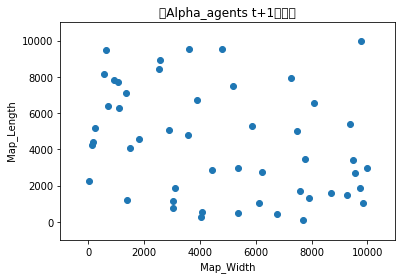

In [116]:
"""
得到初始位置，初始速度
"""
# check part.
AgentsPos = output_graph.nodes
#print(graphs_tuple_np_T)
List1 = []
List2 = []
for i in range(50):
    tmp1 = AgentsPos[i][0]
    tmp2 = AgentsPos[i][1]
    List1.append(tmp1)
    List2.append(tmp2)
x = List1
y = List2
# check part.
plt.scatter(x,y)
plt.title("　Alpha_agents t+1位置　")
plt.xlabel(" Map_Width ")
plt.ylabel(" Map_Length ")
plt.axis([-1000,11000,-1000,11000])
plt.show()